In [13]:
import gym
import random
from keras import Sequential
# import tensorflow as tf
from collections import deque
from keras.layers import Dense
from keras.optimizers import adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear
import psutil
import gc

import numpy as np

In [14]:
env = gym.make('LunarLander-v2')
# Landing pad is always at coordinates (0,0). 
# Coordinates are the first two numbers in state vector. 
# Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. 
# If lander moves away from landing pad it loses reward back. 
# Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. 
# Each leg ground contact is +10. 
# Firing main engine is -0.3 points each frame. Solved is 200 points. 
# Landing outside landing pad is possible. 
# Fuel is infinite, so an agent can learn to fly and then land on its first attempt. 
# Four discrete actions available: do nothing, fire left orientation engine, fire main engine,
#     fire right orientation engine.

print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)
state_size = env.observation_space.shape[0]

Box(8,)
[inf inf inf inf inf inf inf inf]
[-inf -inf -inf -inf -inf -inf -inf -inf]


In [15]:
# # neural network architecture, input=states, output=actions
def build_model(input_size, output_size):
    model = Sequential()
    model.add(Dense(128, input_dim = input_size, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_size, activation = "linear"))
    model.compile(loss='mse', optimizer="Adam")
    return model

![Explanation of environment exploration/exploitation] (https://github.com/VeronikaRevjakina/LunaLander_RL/blob/master/firefox_mQVLhQrl3o.png?raw=true)

[QL](https://www.freecodecamp.org/news/diving-deeper-into-reinforcement-learning-with-q-learning-c18d0db58efe)

In [33]:
def dql_train(env, state_size, action_size, model, train_games_num, max_steps_in_game,batch_size,discount_rate,
              epsilon=1,epsilon_decay = .99):
    iter_num_to_check_stop = 100
    scores = np.array([])
    #object for remembering all things need for dql in memory
    memory = {"state":np.array([]), 
            "action":np.array([], dtype = int), 
            "reward":np.array([]),
            "new_state":np.array([]), 
            "done":np.array([])
            }
    for game in range(train_games_num):
        
        if game == iter_num_to_check_stop:  # check if far away from negativa value to quicker learn
            last_negative_reward_index = np.argwhere(scores<0)[-1]
            positive_tail_length = game - last_negative_reward_index
            if positive_tail_length >= 100:
                break
            else:
                iter_num_to_check_stop = last_negative_reward_index + 100
        obs = env.reset() #to initial state
#         obs = obs.reshape([1,state_size]) # reshape for neural network input
        obs = np.reshape(obs, (1, state_size))
#         np.reshape(obs, (1, state_size))
#         obs = np.reshape(obs, (1, state_size))
        game_score = 0
        
        for step in range(max_steps_in_game):  
            # get an action number random or model
            if np.random.rand() <= epsilon:
                action =int(random.randrange(action_size))  # get random because explore env
            else:
#                 act_values = model(obs) # model predict based on state
#                 action = int(np.argmax(act_values[0]))
                action = np.argmax(model.predict(obs)[0])
#             env.render()
            # take an action
            new_obs, reward, done, info = env.step(action)
#             new_obs = new_obs.reshape([1,state_size]) # reshape for neural network input
            new_obs = np.reshape(new_obs, (1, state_size))
            game_score += reward
        
#             max_len = 250000
#             if len(memory["state"])>= max_len or psutil.virtual_memory().available / (1024.0 ** 3) <=2:
#                 gc.collect()
#                 memory = {"state":np.array([]), 
#                         "action":np.array([], dtype = int), 
#                         "reward":np.array([]),
#                         "new_state":np.array([]), 
#                         "done":np.array([])
#                         }
            #  remember into memory this step
            if len(memory["state"])>0:
                memory["state"] = np.vstack((memory["state"], obs)) # to get matrix of row = state vector of 8 values
                memory["new_state"] = np.vstack((memory["new_state"], new_obs))
            else:
                memory["state"] = np.array(obs) # if not initialized new
                memory["new_state"] = np.array(new_obs)
            memory["action"] = np.append(memory["action"], action)  # just vectors
            memory["reward"] = np.append(memory["reward"], reward)
            memory["done"] = np.append(memory["done"], done)

            obs = new_obs  # change to new state
            
            # if we get data for batch then update model weights with earned data, clear it and start again:
            if len(memory["state"])>=batch_size:
                # randomly sample batch from memory with 64 size always
                indexes = np.random.randint(len(memory["done"]), size=batch_size)
                batch = {
                    "state": np.squeeze(memory["state"][indexes]), 
                    "action": memory["action"][indexes], 
                    "reward": memory["reward"][indexes], 
                    "new_state": np.squeeze(memory["new_state"][indexes]), 
                    "done": memory["done"][indexes]
                    }
                # Bellman's equation for target only for chosen actions, 
                #(1-done) to discard cumilative gain for last actions
                targets = batch["reward"] + \
                        discount_rate*(np.amax(model.predict_on_batch(batch["new_state"]), axis=1))*(1-batch["done"])
                targets_full = model.predict_on_batch(batch["state"])  # needed to fill counted above target 
                # set elements in "indices" to 0's
#                 indices =[]
#                 for i in range(batch_size):
#                     indices.append([i,batch["action"][i]])
#                 values =targets
#                 inputs = targets_full
#                 # set elements in "indices" to 0's
#                 maskValues = tf.tile([0.0], [tf.shape(indices)[0]])  # one 0 for each element in "indices"
#                 mask = tf.SparseTensor(indices, maskValues, tf.shape(inputs, out_type = tf.int64))
#                 maskedInput = tf.multiply(inputs, tf.sparse.to_dense(mask, default_value = 1.0))  # set values in coordinates in "indices" to 0's, leave everything else intact

                # replace elements in "indices" with "values"
#                 delta = tf.SparseTensor(indices, values, tf.shape(inputs, out_type = tf.int64))
#                 outputs = tf.add(tf.cast(maskedInput, tf.float32), tf.cast(tf.sparse.to_dense(delta), tf.float32))  # add "values" to elements in "indices" (which are 0's so far)
                # on performed actions, rest stays as model counted
#                 targets_full[np.array(range(batch_size)), batch["action"]] = targets # change specific indexes
                ind = np.array([i for i in range(batch_size)])
                targets_full[[ind], batch["action"]] = targets
#                 ind = np.array([i for i in range(batch_size)])
#                 targets_full = tf.constant(targets_full[[ind], batch["action"]]) 
#                 print(targets)
#                 print(batch["action"])
#                 print(targets_full)
#                 print(indices)
#                 print(targets)
#                 print(outputs)
                # update model weights
                model.fit(batch["state"], targets_full, epochs = 1, verbose = 0)
                
                if epsilon > 0.01:
                      epsilon *= epsilon_decay  # update exploration/exploitation parameter

            if done: # from step performed
                break

        scores = np.append(scores, game_score)
        if (game+1) % 100 == 0:
            print(f'Avg score for the last {100} games: {np.mean(scores[-100:])}')
    print(f"Evaluate in {game+1} iterations")
    return scores, model
            

In [34]:
games_iter = 400
num_iter = 400
discount_rate = 0.99  # how much depend on long time reward
batch_size = 64  # for sampling from memory, training 
action_size =4 # fixed for environment

model = build_model(state_size, action_size)  #get model of architecture above

traning_score, trained_model = dql_train(env,state_size,action_size, model, games_iter,num_iter,batch_size,discount_rate)
trained_model.save('trained_model.h5')

Avg score for the last 100 games: -11.086008368235428
Avg score for the last 100 games: 45.76813336029838
Avg score for the last 100 games: 42.53700352647241
Avg score for the last 100 games: 46.361457188267785
Evaluate in 400 iterations


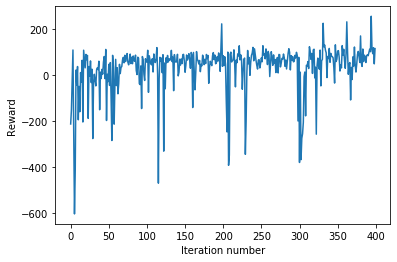

In [37]:
x=list(range(len(traning_score)))
plt.plot(x, traning_score)
plt.xlabel("Iteration number")
plt.ylabel("Reward")
plt.show()

In [ ]:
from keras.models import load_model
model = load_model('trained_model.h5')

In [43]:
test_games_num = 100
test_scores = []
max_steps_in_game = 1000
for game in range(test_games_num):
    score = 0
    obs = env.reset()  # get initial state
    for step in range(max_steps_in_game):
#         env.render()  # show gif
#         print(observation)  # print state vector 8, fixed for environment
        obs = np.reshape(obs, (1, state_size))
        rewards = trained_model.predict(obs)
        action = int(np.argmax(rewards[0]))
#         action = env.action_space.sample()
        obs, reward, done, info = env.step(action)  # step returns 4 parameters
        score +=reward
        if done:  # game over need reset
#             print("Episode finished after {} timesteps".format(step+1))
            print(score)
            break
    test_scores.append(score)

189.79770284226396
18.877309591536843
9.411233999881995
252.19734272982163
28.807237252489074
213.063794154023
-25.59602671741023
-106.04068400536008
23.606301210390093
7.794551316466763
42.169875999900384
245.9856736547068
216.12421978384035
124.23167258405432
0.49933231207410467
46.47078183633605
26.490900772746667
48.20407807436381
-37.58934595070087
156.01672920763937
-6.608450545105266
55.22889978900618
-23.91076577870122
207.3514283183577
17.654428944213542
17.35784372951292
201.35283328331624
51.52839460238884
-22.45106251345304
21.357584076622583
-9.775594724727968
18.12196811973773
-10.072727804621369
45.346024012610904
31.68538268066168
25.342055058396145
17.088663383865487
16.439975697947922
-3.0587305459503007
0.4193390226487339
17.410682592331646
-1.5445217285528277
217.48474167471915
26.31621130669702
19.698620439612764
241.02037911038224
21.584564258882995
-16.972817399724903
223.96154732010154
9.426880878871291
14.506871475970264
2.9512616522877764
222.0020261118931
42.

In [44]:
print("Average reward on test 100 games: ", np.mean(test_scores))

Average reward on test 100 games:  41.17027300938684


In [45]:
test_scores = np.array(test_scores)
print("Number of games in 100 where reward")
print("less than 0: ", len(test_scores[test_scores<0]))
print("equals 0: ", len(test_scores[test_scores==0]))
print("more than 0: ", len(test_scores[test_scores>0]))
print("equals or more than 100: ", len(test_scores[test_scores>=100]))
print("equals or more than 200: ", len(test_scores[test_scores>=200]))

Number of games in 100 where reward
less than 0:  30
equals 0:  0
more than 0:  70
equals or more than 100:  18
equals or more than 200:  15
